# Mental Distress in Expecting Parents: Detecting Anxiety and Depression in Pregnancy-Related Reddit Posts

**Annika Nicole F. Montemayor**

This was a personal machine learning project conducted in **May 2025** to learn more about natural language processing. In this project, we seek to explore whether thoughts and behaviors related to anxiety and depression are prevalent in pregnancy-related posts on Reddit.

This project uses the dataset from the study of [Dhankar & Katz (2023)](https://pmc.ncbi.nlm.nih.gov/articles/PMC10684261/), which extracted Reddit posts from pregnancy- and mental health-related subreddits. For the pregnancy-related subreddits, the posts were taken from the time of the subreddit's creation to November 2022, while the posts from the mental health-related subreddits were extracted from 2018 to the same end date.

## Preliminaries

We first import all relevant libraries.

In [1]:
# Relevant installations
# !pip install fastparquet
# !pip install contractions
# !pip install torch
# !pip install transformers

# Data Management
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# NLP Preliminaries
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Machine Learning

# TF-IDF + Logistic Regression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# BERT
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss

# Warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\lib\site-packages\transformers\utils\generic.py:500: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\user\anaconda3\lib\site-packages\transformers\utils\generic.py:357: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(
C:\Users\user\anaconda3\lib\site-packages\transformers\utils\generic.py:357: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


### Data Pre-Processing

First, we import the `.parquet` file using the recommended code written in the Open Science Framework Data Repository.

We then conduct preliminary data cleaning procedures:
* We set the index of the DataFrame to be `id`, which is the alphanumeric ID assigned to each Reddit post.
* We drop any row that has empty content in the `selftext` column (i.e., the post content).
* We convert the `created_utc` column to its appropriate format.
* We combine the `title` and `selftext` columns in the `all_text` column to document all the text included in one Reddit post.

In [2]:
preg_anx = pd.read_parquet('pregnant_anxiety_reddit_parquet_file.parquet', engine = 'fastparquet')
preg_anx = preg_anx.set_index('id')
preg_anx.dropna(subset = ['selftext'], how = 'any', inplace = True)
preg_anx['created_utc'] = pd.to_datetime(preg_anx['created_utc'], unit = 's')
preg_anx['all_text'] = (preg_anx['title'].fillna('') + ' ' + preg_anx['selftext'].fillna('')).str.strip()

This is a preview of our dataset.

In [3]:
preg_anx.head(5)

,subreddit,author,created_utc,title,selftext,all_text
id,,,,,,
8v312r,BabyBumpsCanada,vibrantmama,2018-06-30 16:38:28,Introductions!,Introduce yourself as much as you'd like.,Introductions! Introduce yourself as much as y...
8v36mz,BabyBumpsCanada,vibrantmama,2018-06-30 17:00:29,Have you thought about how long you're taking ...,"I should know this, but I don't, but is the 18...",Have you thought about how long you're taking ...
8v9ih7,BabyBumpsCanada,Chan_Vaen_edan_Kote,2018-07-01 12:17:24,Happy Canada Day!,We’re in Montreal where Canada Day is sort of ...,Happy Canada Day! We’re in Montreal where Cana...
8vancf,BabyBumpsCanada,klhwhite,2018-07-01 15:30:32,Sick leave during pregnancy cutting into mat l...,I was on sick leave and receiving benefits for...,Sick leave during pregnancy cutting into mat l...
8vm5qf,BabyBumpsCanada,watercity,2018-07-02 20:52:34,Which provinces/cities/areas are the best for ...,"In your opinion, of course. :) Thanks!",Which provinces/cities/areas are the best for ...


We perform more data cleaning procedures, similar to those outlined in [Dhankar & Katz (2023)](https://pmc.ncbi.nlm.nih.gov/articles/PMC10684261/).
* We drop all posts from user `AutoModerator` (a bot).
* We drop all posts that have been removed or have deleted users.
* We drop all posts containing the words "discuss",  "daily", and "weekly". The previous researchers argued that these may include posts that are part of regularly hosted discussion threads in the subreddits. Engagements with these posts often do not warrant full-blown discussions (i.e., requiring an own thread), so they are unlikely to contain information about the user's thoughts and behaviors. 

In [4]:
preg_anx = preg_anx[~(
    preg_anx['author'].isin(['AutoModerator', '[deleted]']) |
    preg_anx['all_text'].str.contains(r'\b(discuss|daily|weekly)\b|\[removed\]', case=False, regex=True)
)].copy()

In [5]:
print(f"At this point, our dataset has {preg_anx.shape[0]} rows and {preg_anx.shape[1]} columns.")

At this point, our dataset has 1732941 rows and 6 columns.


The following block of code tell us that we do not have any missing data in any of the columns. Additionally, we count how many posts have been recorded under each subreddit.

In [6]:
preg_anx.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       0
all_text       0
dtype: int64

In [7]:
preg_anx['subreddit'].value_counts()

subreddit
depression           537673
SuicideWatch         338625
BabyBumps            316397
Anxiety              254923
pregnant             149637
HealthAnxiety         39349
depression_help       35319
depressed             19822
AnxietyDepression     13412
PanicAttack           11945
BabyBumpsCanada        7038
CoronaBumpers          5908
PregnancyUK            2893
Name: count, dtype: int64

We split our dataset into `preg` and `anx` to indicate posts that belong to pregnancy- and mental health-related subreddits, respectively.

In [8]:
preg = preg_anx[preg_anx['subreddit'].isin(['BabyBumps', 'pregnant', 'BabyBumpsCanada', 'CoronaBumpers', 'PregnancyUK'])]
anx = preg_anx[preg_anx['subreddit'].isin(['depression', 'SuicideWatch', 'Anxiety', 'HealthAnxiety', 'depression_help', 'depressed', 'AnxietyDepression', 'PanicAttack'])]

To avoid bias towards the thoughts and behaviors of a specific user, we only take one post from each `author` recorded in each subset of our data. This was done by shuffling the order of the entries in our dataset and only keeping the first entry. 

In [9]:
preg_shuffled = preg.sample(frac = 1, random_state = 42)
preg_sample = preg_shuffled[~preg_shuffled['author'].duplicated(keep = 'first')]

anx_shuffled = anx.sample(frac = 1, random_state = 42)
anx_sample = anx_shuffled[~anx_shuffled['author'].duplicated(keep = 'first')]

In [10]:
print(f"At this point, our pregnancy subset has {preg_sample.shape[0]} rows and {preg_sample.shape[1]} columns.")

print("This is a preview of our pregnancy subset.")
preg_sample.head(5)

At this point, our pregnancy subset has 125765 rows and 6 columns.
This is a preview of our pregnancy subset.


,subreddit,author,created_utc,title,selftext,all_text
id,,,,,,
tx9jir,pregnant,luckywolfpaw,2022-04-06 00:35:09,Umbilical granuloma,So we just left our pediatrician appointment a...,Umbilical granuloma So we just left our pediat...
vigegm,BabyBumps,Any_Day12,2022-06-22 21:46:33,Feeling miserable at 24 weeks. Return of first...,I had been feeling pretty good since about 16 ...,Feeling miserable at 24 weeks. Return of first...
80y7y2,BabyBumps,Latest_Medical_News,2018-02-28 18:18:01,Is Prenatal Vitamin D Linked to Low Birth Weight?,,Is Prenatal Vitamin D Linked to Low Birth Weight?
ot2qe3,pregnant,Militarykid2111008,2021-07-28 04:27:14,Im scared//ranting kinda,"I’m pregnant with my first, due in January. An...",Im scared//ranting kinda I’m pregnant with my ...
9olqp8,BabyBumps,Dopeyk,2018-10-16 08:42:20,Freaking out about lack of support for Baby #3...,I am 26 weeks along with my third child. I ha...,Freaking out about lack of support for Baby #3...


In [11]:
print(f"At this point, our mental health subset has {anx_sample.shape[0]} rows and {anx_sample.shape[1]} columns.")

print("This is a preview of our mental health subset.")
anx_sample.head(5)

At this point, our mental health subset has 616903 rows and 6 columns.
This is a preview of our mental health subset.


,subreddit,author,created_utc,title,selftext,all_text
id,,,,,,
bz6tr8,depression,bornsic,2019-06-11 02:28:17,Turned 25yo today,Bittersweet feeling. I made a promise to mysel...,Turned 25yo today Bittersweet feeling. I made ...
gwiyvv,Anxiety,cthowellheat,2020-06-04 14:54:27,Does anyone else feel ok when distracted but p...,I notice this happens when I am fully distract...,Does anyone else feel ok when distracted but p...
hac2xg,Anxiety,overthinkersquad,2020-06-16 20:31:25,how to reach happiness ?,,how to reach happiness ?
b50frc,depression,mindkingdom,2019-03-24 19:35:15,My isolation has made me weird,"Hey everyone,\n\n\n\nI don't really know how t...","My isolation has made me weird Hey everyone,\n..."
aegr9e,depression,Flippius,2019-01-10 07:25:27,Just run me over with a car already,I am so SICK of life. It is complete and utter...,Just run me over with a car already I am so SI...


We now attempt to label the mental health subset by using their subreddits as pseudo-labels. We seek to perform multi-label classification, where we indicate whether or not the user is exhibiting anxiety and/or depression. We check the value counts at the end of the block, and there is intentionally none labelled as `[0,0]`.

In [12]:
def assign_label(subreddit):
    if subreddit in ['Anxiety', 'HealthAnxiety', 'PanicAttack']:
        return [1, 0]  # Anxiety only
    elif subreddit in ['depression', 'depression_help', 'depressed']:
        return [0, 1]  # Depression only
    elif subreddit in ['SuicideWatch', 'AnxietyDepression']:
        return [1, 1]  # Both
    else:
        return [0, 0]  # None, just in case

anx_sample['label'] = anx_sample['subreddit'].apply(assign_label)
anx_sample['label'].value_counts()

label
[0, 1]    294873
[1, 1]    177481
[1, 0]    144549
Name: count, dtype: int64

### Exploratory Data Analysis

For each subset of our data, we first assess the total number of posts (overall and yearly) per subreddit.

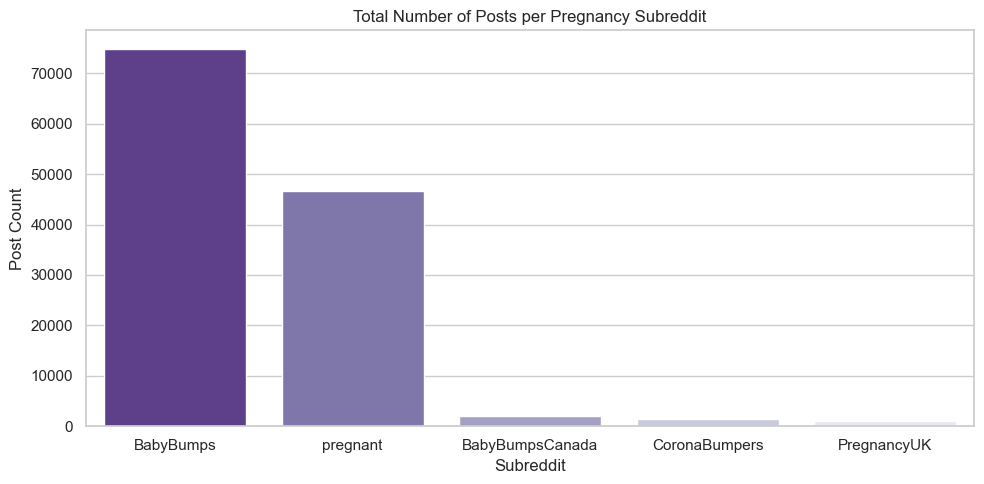

In [13]:
bar_data = preg_sample['subreddit'].value_counts().reset_index()
bar_data.columns = ['subreddit', 'count']

plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
sns.barplot(data=bar_data, x='subreddit', y='count', palette='Purples_r')

plt.title('Total Number of Posts per Pregnancy Subreddit')
plt.ylabel('Post Count')
plt.xlabel('Subreddit')
plt.tight_layout()
plt.show()

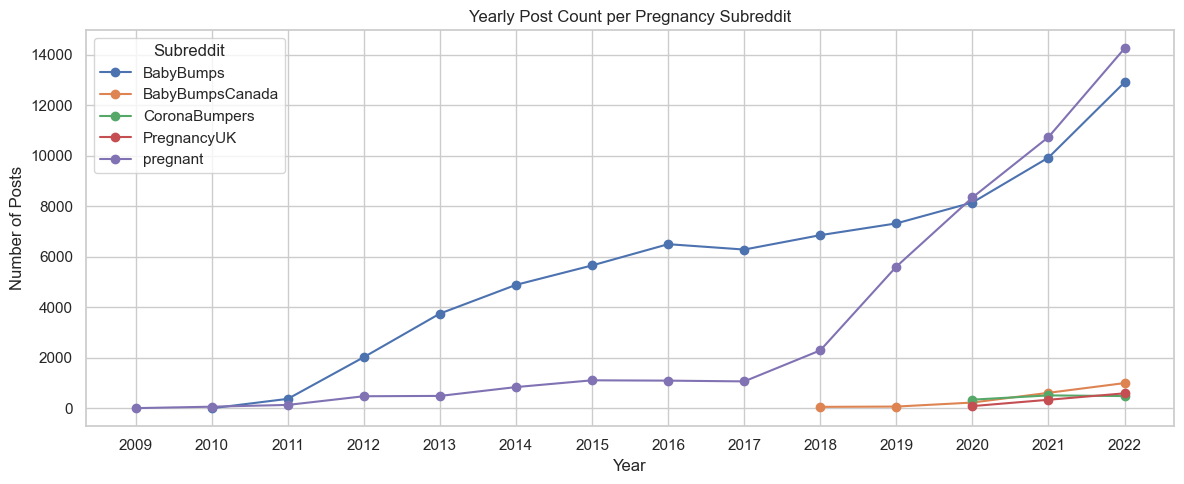

In [14]:
preg_sample['year'] = preg_sample['created_utc'].dt.year

yearly_counts = preg_sample.groupby(['subreddit', 'year']).size().reset_index(name='count')

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

for subreddit in yearly_counts['subreddit'].unique():
    data = yearly_counts[yearly_counts['subreddit'] == subreddit]
    plt.plot(data['year'], data['count'], marker='o', label=subreddit)

plt.title('Yearly Post Count per Pregnancy Subreddit')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(yearly_counts['year'].unique(), rotation=0)
plt.legend(title='Subreddit', loc='upper left')
plt.tight_layout()
plt.show()

From the bar chart, `BabyBumps` and `pregnant` have the most posts in total, but this may also be attributed to the fact that they are also the oldest subreddits in the dataset, starting in 2009 and 2010, respectively. The line plot indicates a generally increasing trend for most subreddits, but it can be observed that `pregnant` has surpassed `BabyBumps` in annual post counts by 2020.

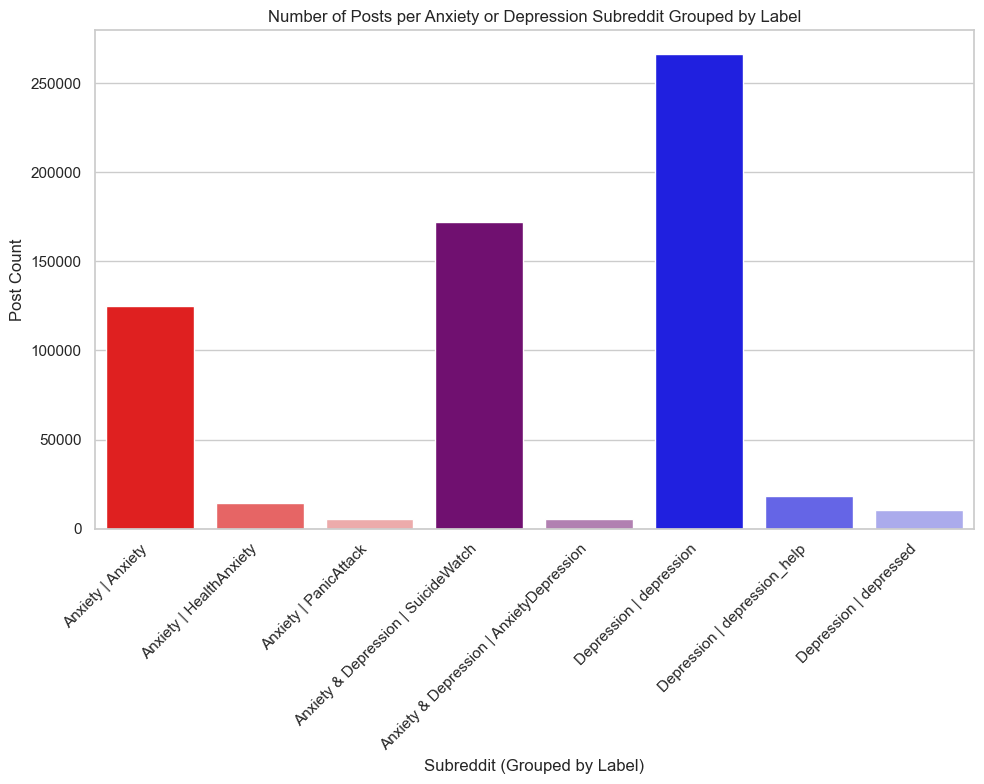

In [15]:
def label_to_str(label):
    if label == [1, 0]:
        return "Anxiety"
    elif label == [0, 1]:
        return "Depression"
    elif label == [1, 1]:
        return "Anxiety & Depression"

anx_sample['label_str'] = anx_sample['label'].apply(label_to_str)

plot_data = anx_sample.groupby(['label_str', 'subreddit']).size().reset_index(name='count')

label_order = ["Anxiety", "Anxiety & Depression", "Depression"]
plot_data['label_str'] = pd.Categorical(plot_data['label_str'], categories=label_order, ordered=True)
plot_data = plot_data.sort_values(by=['label_str', 'count'], ascending=[True, False])

plot_data['x_label'] = plot_data['label_str'].astype(str) + ' | ' + plot_data['subreddit']

palette_map = {
    "Anxiety" : sns.light_palette("red", n_colors= 1 + len(anx_sample[anx_sample['label_str'] == 'Anxiety']['subreddit'].unique()), reverse=True),
    "Anxiety & Depression" : sns.light_palette("purple", n_colors= 1 + len(anx_sample[anx_sample['label_str'] == 'Anxiety & Depression']['subreddit'].unique()), reverse=True),
    "Depression" : sns.light_palette("blue", n_colors=1 + len(anx_sample[anx_sample['label_str'] == 'Depression']['subreddit'].unique()), reverse=True),
}

color_list = []
for label in label_order:
    group = plot_data[plot_data['label_str'] == label]
    shades = palette_map[label]
    for i in range(len(group)):
        color_list.append(shades[i % len(shades)])

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

sns.barplot(
    data=plot_data,
    x='x_label',
    y='count',
    palette=color_list
)

plt.title('Number of Posts per Anxiety or Depression Subreddit Grouped by Label')
plt.ylabel('Post Count')
plt.xlabel('Subreddit (Grouped by Label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

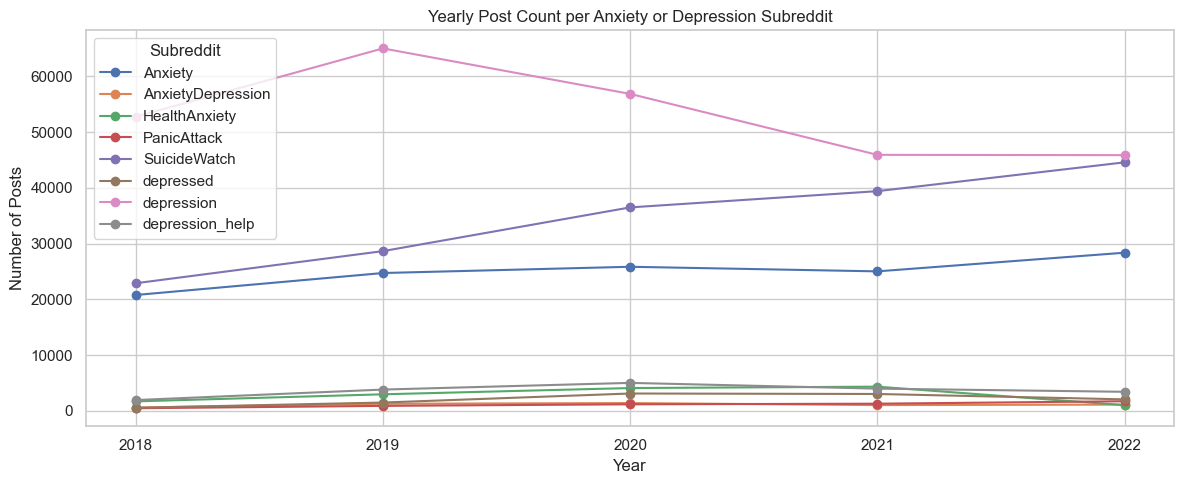

In [16]:
anx_sample['year'] = anx_sample['created_utc'].dt.year

yearly_counts = anx_sample.groupby(['subreddit', 'year']).size().reset_index(name='count')

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

for subreddit in yearly_counts['subreddit'].unique():
    data = yearly_counts[yearly_counts['subreddit'] == subreddit]
    plt.plot(data['year'], data['count'], marker='o', label=subreddit)

plt.title('Yearly Post Count per Anxiety or Depression Subreddit')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(yearly_counts['year'].unique(), rotation=0)
plt.legend(title='Subreddit', loc='upper left')
plt.tight_layout()
plt.show()

For each label, `Anxiety`, `Depression`, and `SuicideWatch` have the most posts in total, which may be related to the straightforwardness and simplicity of the subreddit's name. While the line plot also indicates a gradual increase as time progresses, it can be observed that the annual post count for the `depression` subreddit spikes in 2019, which may be related to the feelings of isolation and uncertainty brought by the COVID-19 pandemic.

To manage the feasibility of this project, we only considered posts from the year 2022. We further took a random sample of 1000 entries for each subset.

In [17]:
preg_2022 = preg_sample[preg_sample['year'] == 2022] 
anx_2022 = anx_sample[anx_sample['year'] == 2022]

print(f"At this point, we have {preg_2022.shape[0]} rows and {preg_2022.shape[1]} columns for the pregnancy subset, and {anx_2022.shape[0]} rows and {anx_2022.shape[1]} columns for the mental health subset.")

preg_2022_sample = preg_2022.sample(n = 1000, random_state = 42)
anx_2022_sample = anx_2022.sample(n = 1000, random_state = 42)

At this point, we have 29273 rows and 7 columns for the pregnancy subset, and 128204 rows and 9 columns for the mental health subset.


We now generate word clouds to visualize the top 200 words for each subset.

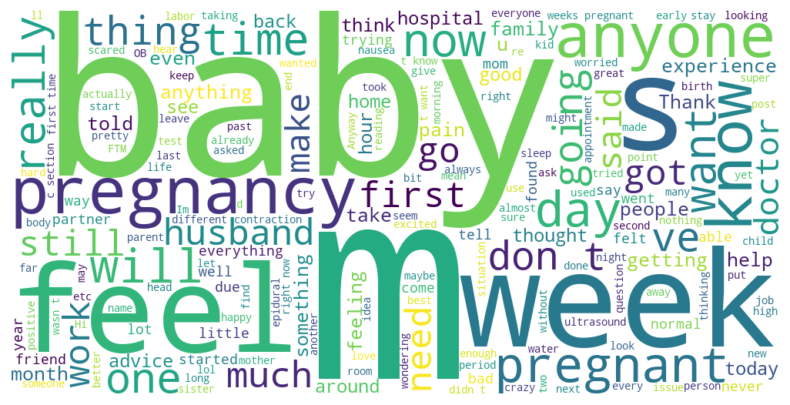

In [18]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 200, background_color = 'white').generate(' '.join(preg_2022_sample['all_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

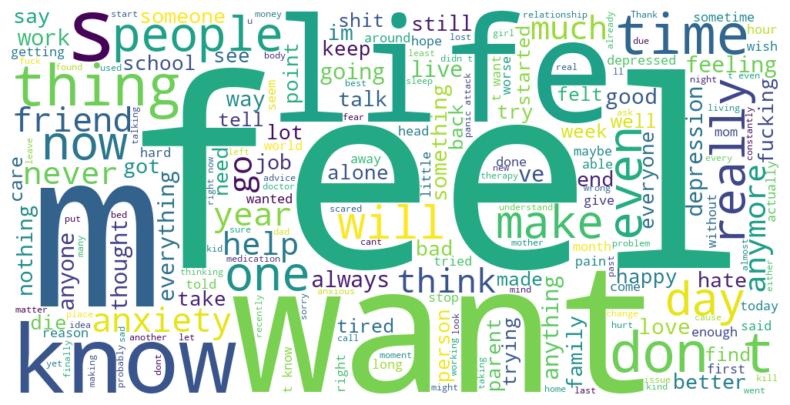

In [19]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 200, background_color = 'white').generate(' '.join(anx_2022_sample['all_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Both word clouds generally show expected results. Notably, "feel" also shows up frequently here (and is also a common word in mental health subreddits), which is a good indicator that the posts discuss the authors' feelings.

## NLP Preliminaries

In [20]:
string.punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

We attempt to create two models using the ff.:
* Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer with Logistic Regession (LogR) Classification
* Bidirectional Encoder Representations from Transformers (BERT)

## TF-IDF + LogR

For our TF-IDF + LogR model, we perform standard pre-processing procedures, which includes the following:
* Fixing contractions (e.g., converting "I'm" to "I am")
* Removing emojis, punctuations, and whitespace
* Formatting the text as lowercase
* Tokenizing the content (splitting each sentence into words, e.g., "i am sad" to "i", "am", "sad")
* Removing stopwords (i.e., common text, e.g., "i", "am")
* Tagging the part of speech (POS) for each token
* Lemmatizing the tokens (reducing each word to its base form)

Running the function `preprocess()` returns the list of lemmas for each post, so we simply concatenate the entries to convert it to a string.

In [21]:
# Standard preprocessing procedures

# Clean text: remove contractions, punctuation, emojis
def clean_text(text):
    text = contractions.fix(text)

    # Remove emojis
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    return text.lower().strip()

# Convert POS tag format from nltk to WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize, remove stopwords, lemmatize
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tagged = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]

anx_2022['lemma_token'] = anx_2022['all_text'].apply(lambda x: preprocess(x)).apply(lambda y: ' '.join(y))

We now train the TF-IDF + LogR model. Given that this method is computationally inexpensive, we train it on `anx_2022`, which contains all mental health-related posts in 2022.

In [22]:
# Features
vectorizer = TfidfVectorizer(max_features = 10000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(anx_2022['lemma_token'])

# Targets
y_tfidf = np.array(anx_2022['label'].tolist())

# Train-test split
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, y_tfidf, test_size = 0.2, random_state = 42
)

# Model: One-vs-Rest Logistic Regression
model_tfidf = OneVsRestClassifier(LogisticRegression(max_iter = 1000))
model_tfidf.fit(X_tfidf_train, y_tfidf_train)

# Prediction
y_tfidf_pred = model_tfidf.predict(X_tfidf_test)

# Evaluation
print("Classification Report")
print(classification_report(y_tfidf_test, y_tfidf_pred, target_names=['Anxiety', 'Depression']))

hloss_tfidf = hamming_loss(y_tfidf_test, y_tfidf_pred)
print(f"Hamming Loss: {hloss_tfidf:.4f}")

Classification Report
              precision    recall  f1-score   support

     Anxiety       0.80      0.84      0.82     15315
  Depression       0.94      0.98      0.96     19536

   micro avg       0.88      0.92      0.90     34851
   macro avg       0.87      0.91      0.89     34851
weighted avg       0.88      0.92      0.90     34851
 samples avg       0.90      0.93      0.90     34851

Hamming Loss: 0.1408


The classification report indicates the model's ability to predict anxiety and/or depression individually. The metrics for each category generally show favorable results, scoring 80\% or more. Additionally, the Hamming loss was also computed, which is a penalty imposed on (partially) incorrect classifications. This allows us to gauge whether the model can predict well for both categories. The results are also favorable for this metric as the loss was close to 0.

## BERT

Next, we move to our BERT model. In contrast to the pre-processing procedures for the previous method, we simply execute the function `basic_clean_text()` to remove URLs and excess whitespace. 

In [23]:
def basic_clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\s+", " ", text)  # Remove whitespace
    return text.strip()

anx_2022_sample['clean_text'] = anx_2022_sample['all_text'].apply(lambda x: basic_clean_text(x))

The following block of code houses the definition of two classes: `RedditDataset`, which extracts the data, and `BertMultiLabelClassifier`, which fits, scores, and saves a BERT multilabel classifier model.

As evidenced by `retrain = False`, we are simply loading the model that was previously trained on `anx_2022_sample` then scoring on the test set. However, should one wish to retrain the model, one must simply set `retrain = True` so that the model can be fit on the training set and saved for future use.

In [24]:
# Step 1: Dataset wrapper
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

# Step 2: BERTClassifier
class BERTMultiLabelClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='bert-base-uncased', num_labels=2, epochs=3, batch_size=8, lr=2e-5):
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, problem_type="multi_label_classification"
        )
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def fit(self, X, y):
        train_dataset = RedditDataset(X, y, self.tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.model.train()

        for epoch in range(self.epochs):
            total_loss = 0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            print(f"Epoch {epoch+1} - Avg Loss: {total_loss / len(train_loader):.4f}")
        return self

    def predict(self, X):
        self.model.eval()
        val_dataset = RedditDataset(X, [[0]*self.model.config.num_labels]*len(X), self.tokenizer)  # dummy labels
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        all_preds = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                probs = torch.sigmoid(outputs.logits)
                preds = (probs > 0.5).int().cpu().numpy()
                all_preds.extend(preds)

        return all_preds

    def score(self, X, y_true):
        y_pred = self.predict(X)
        print(classification_report(y_true, y_pred, target_names=['Anxiety', 'Depression']))

        hloss = hamming_loss(y_true, y_pred)
        print(f"Hamming Loss: {hloss:.4f}")

    def save(self, model_path="bert_model_weights.pt", tokenizer_path="bert_tokenizer/"):
        torch.save(self.model.state_dict(), model_path)
        self.tokenizer.save_pretrained(tokenizer_path)

    @classmethod
    def load(cls, model_path, tokenizer_path, **kwargs):
        instance = cls(**kwargs)
        instance.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        instance.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=2, problem_type="multi_label_classification"
        )
        instance.model.load_state_dict(torch.load(model_path, map_location=instance.device))
        instance.model.to(instance.device)
        instance.model.eval()
        return instance

# List conversion
X_bert = anx_2022_sample['clean_text'].tolist()
y_bert = anx_2022_sample['label'].tolist()

# Train-test split
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
    X_bert, y_bert, test_size = 0.2, random_state = 42
)

# Training or loading the model
retrain = False 

if retrain:
    model_bert = BERTMultiLabelClassifier()
    model_bert.fit(X_bert_train, y_bert_train)
    model_bert.save("bert_model_weights.pt", "bert_tokenizer/")
else:
    model_bert = BERTMultiLabelClassifier.load("bert_model_weights.pt", "bert_tokenizer/")

# Evaluation
model_bert.score(X_bert_test, y_bert_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

     Anxiety       0.82      0.82      0.82       108
  Depression       0.95      0.99      0.97       152

   micro avg       0.90      0.92      0.91       260
   macro avg       0.89      0.91      0.90       260
weighted avg       0.90      0.92      0.91       260
 samples avg       0.92      0.94      0.91       260

Hamming Loss: 0.1175


Similar to the TF-IDF + LogR model, the evaluation metrics show favorable results for the BERT model. The classification report metrics all have scores greater than 80\%, while the Hamming loss was also relatively close to 0.

## Model Comparison

In comparing both models, we can observe that the BERT model already performs similar to the TF-IDF + LogR model even when it is only working on a sample of the data and with only 3 epochs. On one hand, this tells us of the possibility of the BERT model to perform better if it is given more data and/or it is trained with more epochs.

On the other hand, we want to consider the cost of utilizing the models. It is more computationally expensive to train the dataset using BERT. Given the parameters stated above, the runtime for training the model was approximately 3 hours. In the use case of predicting whether posts outside of mental health subreddits exhibit mental distress, it is important to employ a model that can quickly verify this to extend the appropriate interventions immediately and effectively.

Given these circumstances, the TF-IDF + LogR model might be more appropriate for its use case. It is computationally efficient, but despite its simplicity, it performs well on the entire dataset based on our chosen evaluation metrics.

## Application on the Pregnancy Subreddits

We now make predictions on the pregnancy subreddits using our chosen model. We conduct the necessary preliminaries using `preprocess()` once again, then call `predict()`. Shown below are the value counts for each category and the word clouds for each set.

In [25]:
preg_2022['lemma_token'] = preg_2022['all_text'].apply(lambda x: preprocess(x)).apply(lambda y: ' '.join(y))
preg_pred = model_tfidf.predict(vectorizer.transform(preg_2022['lemma_token']))

preg_2022[['pred_anxiety', 'pred_depression']] = preg_pred
preg_2022[['pred_anxiety', 'pred_depression']].value_counts()

pred_anxiety  pred_depression
1             1                  12992
              0                  10433
0             1                   5168
              0                    680
Name: count, dtype: int64

Out of all the posts from the chosen pregnancy subreddits in 2022,
* 12,992 exhibit both anxiety and depression.
* 10,433 only exhibit anxiety.
* 5,168 only exhibit depression.
* 680 exhibit neither.

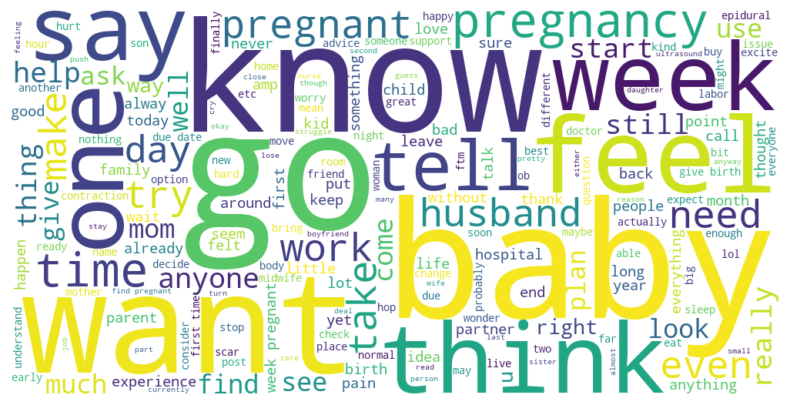

In [26]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 200, background_color = 'white').generate(' '.join(
    preg_2022[(preg_2022['pred_anxiety'] == 1) & (preg_2022['pred_depression'] == 1)]['lemma_token']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

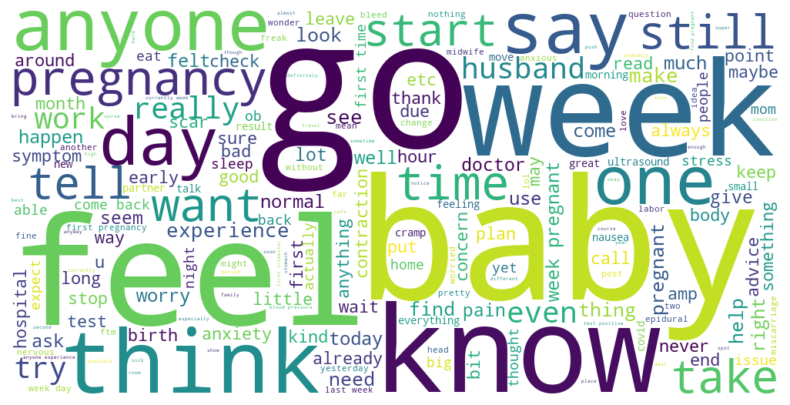

In [27]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 200, background_color = 'white').generate(' '.join(
    preg_2022[(preg_2022['pred_anxiety'] == 1) & (preg_2022['pred_depression'] == 0)]['lemma_token']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

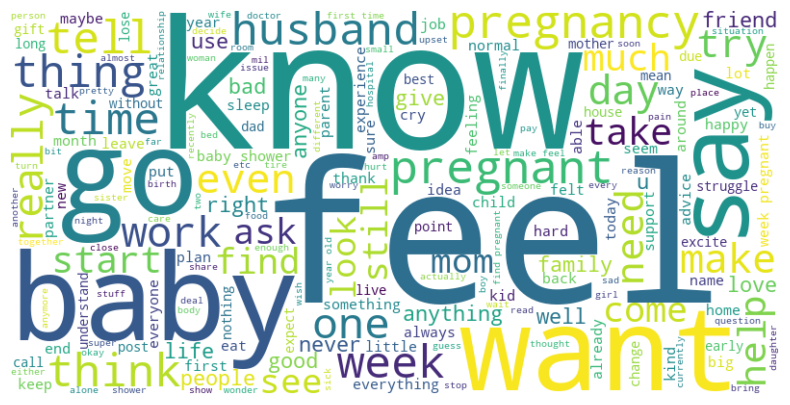

In [28]:
wordcloud = WordCloud(width = 800, height = 400, max_words = 200, background_color = 'white').generate(' '.join(
    preg_2022[(preg_2022['pred_anxiety'] == 0) & (preg_2022['pred_depression'] == 1)]['lemma_token']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

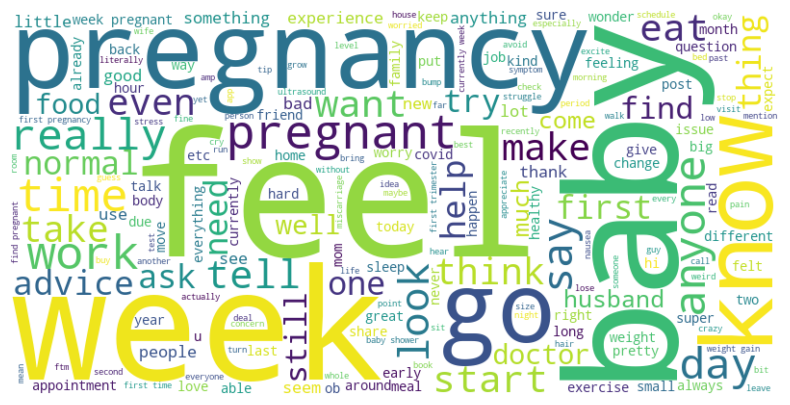

In [29]:
wordcloud = WordCloud(width = 800, height = 400, max_words = 200, background_color = 'white').generate(' '.join(
    preg_2022[(preg_2022['pred_anxiety'] == 0) & (preg_2022['pred_depression'] == 0)]['lemma_token']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We now seek to examine the most influential tokens in determining the classifications. Positive tokens under a specific category increase the probability that a post with that token would be classified under that category, while negative tokens do the opposite.

In [30]:
feature_names = vectorizer.get_feature_names_out()
logreg_models = model_tfidf.estimators_

def get_top_tokens(classifier, feature_names, top_n=20):
    coefs = classifier.coef_[0]
    top_positive_idx = np.argsort(coefs)[-top_n:][::-1]  # Highest weights
    top_negative_idx = np.argsort(coefs)[:top_n]         # Lowest weights

    return {
        "Top Positive Tokens": [(feature_names[i], coefs[i]) for i in top_positive_idx],
        "Top Negative Tokens": [(feature_names[i], coefs[i]) for i in top_negative_idx]
    }

print("Anxiety (0)")
anx_tokens = get_top_tokens(logreg_models[0], feature_names)
print(pd.DataFrame(anx_tokens))
print("\n")
print("Depression (1)")
dep_tokens = get_top_tokens(logreg_models[1], feature_names)
print(pd.DataFrame(dep_tokens))

Anxiety (0)
                 Top Positive Tokens                       Top Negative Tokens
0      (anxiety, 18.172748220183216)         (depression, -17.175425297571895)
1        (anxious, 9.14313647546069)             (depress, -9.255287223098625)
2         (panic, 6.428647173347994)           (depressed, -7.901932414865352)
3      (suicidal, 5.323834148367807)           (depressive, -6.67416216166789)
4      (suicide, 5.2626592419090885)  (depression anxiety, -4.740682918870417)
5            (kill, 4.5443705332122)                (mdd, -4.3981263082145095)
6           (gad, 4.382912939509899)     (antidepressant, -3.6221154435426866)
7      (nervous, 3.9373825295057565)         (motivation, -3.5863854086517155)
8      (attempt, 3.8100138369731593)     (social anxiety, -3.5559110058760783)
9          (gun, 3.7730232317908707)             (sadness, -3.080256110620252)
10       (freak, 3.7611687531650206)                 (cry, -2.949486477090336)
11      (buspar, 3.3857485700452075)    

From the list, it can be observed that...
* Straightforwardly, the top anxiety-related tokens are `anxiety`, `anxious`, and `panic`, while the top depression-related tokens are `depression`, `depress`, and `depressed`.
* Most of the top negative tokens for anxiety are found in the top positive tokens for depression and vice versa. We note that this may be caused by the pseudo-classifications conducted at the start of the study, where posts under anxiety-related subreddits are deemed to only exhibit anxiety and not depression. The same applies to depression-related subreddits.
* Some of the top positive tokens under anxiety feature medications often taken to alleviate its symptoms, such as Buspirone (often sold under the brand name Buspar) and Propranolol. Meanwhile, only `antidepressant` can be found under those for depression.
* Suicide-related tokens show up as positive tokens for both classifications. We note that this may be caused by our pseudo-classification of the subreddit `SuicideWatch` under both anxiety and depression. However, it can also be seen that more suicide-related terms are found under the list for depression, such as `attempt`, `end`, `overdose`, and `die`.

We now count how frequently the top positive tokens for each category appear in the pregnancy subreddits.

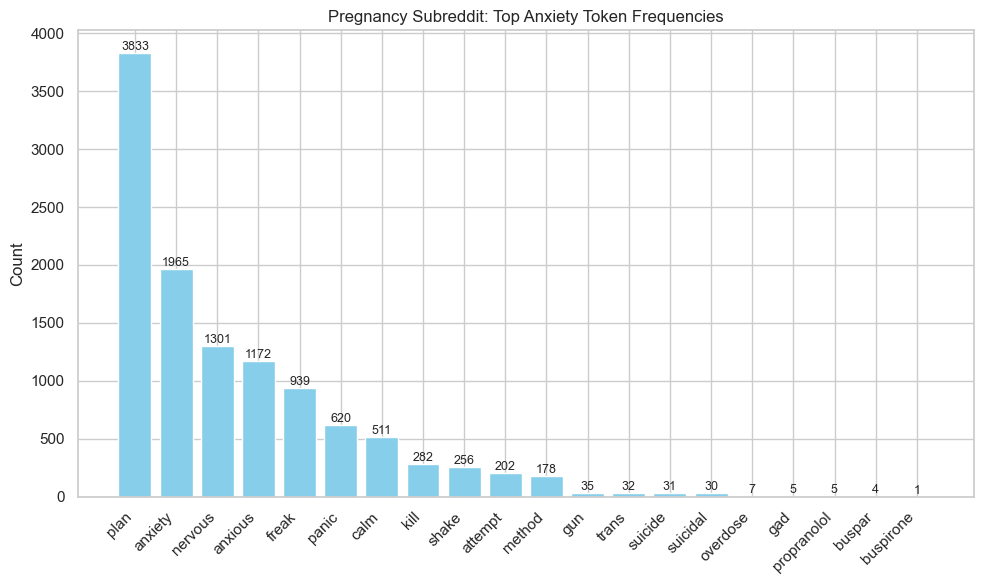

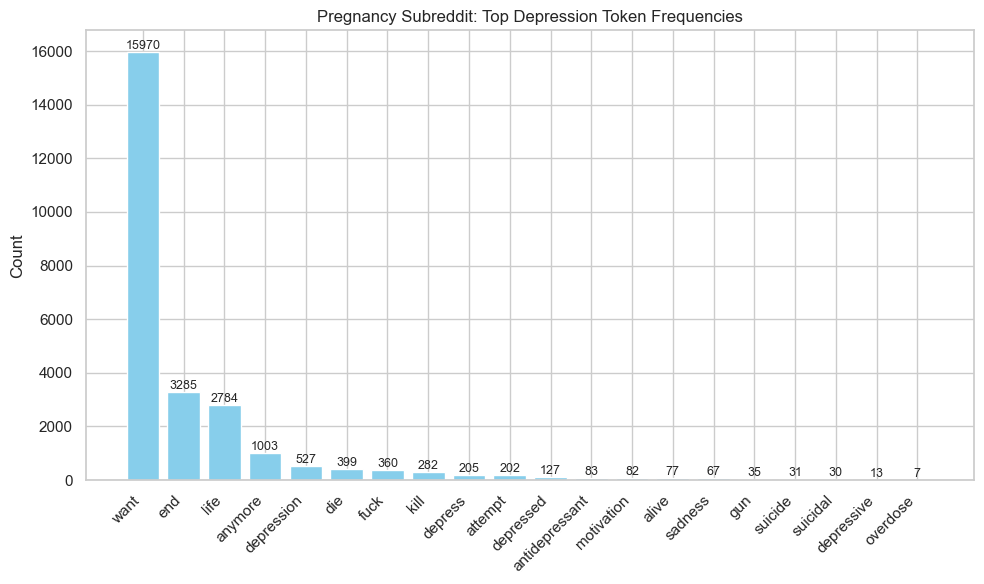

In [31]:
preg_tokens_split = [token for row in preg_2022['lemma_token'].apply(str.split) for token in row]
preg_token_counts = Counter(preg_tokens_split)

# Sorted token frequencies for a given token list
def token_count(top_token_tuples):
    top_tokens = [token for token, _ in top_token_tuples]
    return sorted([(token, preg_token_counts[token]) for token in top_tokens if token in preg_token_counts],
                  key=lambda x: x[1], reverse=True)

anx_counts = token_count(anx_tokens['Top Positive Tokens'])
dep_counts = token_count(dep_tokens['Top Positive Tokens'])

def plot_token_counts(data, title):
    tokens, counts = zip(*data)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(tokens, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title(title)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 str(count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_token_counts(anx_counts, "Pregnancy Subreddit: Top Anxiety Token Frequencies")
plot_token_counts(dep_counts, "Pregnancy Subreddit: Top Depression Token Frequencies")

From the plots, it can be observed that...
* `plan` and `want` are the most frequent tokens under each category, but we also note that these words might not strictly refer to mental distress as they may be related to other matters, such as pregnancy plans and parenthood-related desires.
* Nonetheless, anxiety- and depression-related tokens are still prevalent in pregnancy subreddits. Behind `plan`, we have `anxiety`, `nervous`, and `anxious` as the next most frequent tokens under those categorized under anxiety. Meanwhile, tokens potentially related to suicidal ideation (e.g., `end`, `life`, `die`) also appear in the posts categorized under depression.

## Summary

These results indicate that mental distress is indeed a relevant concern in pregnancy (and potentially, parenthood), thereby echoing the increasing need for expecting parents to receive the appropriate mental and emotional support during this major chapter of their lives. In general, this support may be evident in mental health-centered circles (e.g., subreddits) and other similar spaces (e.g., inputting these topics into search engines), but it is important for us to identify and act on these behaviors even outside these areas.

Natural language processing may be used as a tool for support in this case, where it can be trained on posts exhibiting mental distress in mental health-related texts to predict the presence of these behaviors in different areas. Upon the identification of mentally distressing behavior, authors of these posts may be offered mental health assistance and/or redirected to the appropriate channels to seek help about their concerns.